In [1]:
# Program description and package imports

"""
There are 1,367 vertices in the dataset.
There are 93,5028 possible connections between 1,367 vertices, of which 93,1289 have edges in our dataset, and the remainder are not connected.
The total number of edges in these 931289 connections is 12,227,223
There are 22,967 keywords in total -- 10,106 keywords have weight >=1; 12,861 have weight = 0

df_selected_kw_graph2['source'] = df_selected_kw_graph2['source'].apply(lambda x: 'v' + str(x))
df_selected_kw_graph2['target'] = df_selected_kw_graph2['target'].apply(lambda x: 'v' + str(x))
df_selected_kw_graph2.columns = ['from', 'to', 'kw_text', 'edge_ID', 'weight']

Strategy: 
1) Perform as much pre-computation on data as possible, and store in ftr files for fast loading without delays in processing.  This includes two key dataframes:
    a) df_graph:  a dataframe with columns ['from', 'to', 'edge_ID']  (stored in file: BASE_DIRECTORY / "Entire_Graph_exploded_merged_df.ftr")
        Explode graph so there is one row per edge, and create a hashable string key for each vertex ("from", "to").  Merge on kw_text to get the correct edge_ID for each row.  Delete columns for kw_text and edge weight to minimize DataFrame size. (This can be retrieved from the original DataFrame file BASE_DIRECTORY / "Entire_Graph_df_exploded.ftr" if needed.)  The lightweight DataFrame info/head looks as follows:

        Int64Index: 12227223 entries, 0 to 12227222
        Data columns (total 3 columns):
        #   Column   Dtype 
        ---  ------   ----- 
        0   from     string
        1   to       string
        2   edge_ID  string
        dtypes: string(3)
        memory usage: 373.1 MB

           from  to  edge_ID
        0   V0   V1  E00130
        1   V0   V3  E00130
        2   V0   V6  E00130
        3   V0   V9  E00130
        4   V0  V10  E00130

    b) df_kw_weights:  a dataframe with columns ['edge_ID', 'weight', 'kw_text']  (stored in file: BASE_DIRECTORY / "All_Keyword_Weights.ftr")
        Remove keywords with weight = 0, and sort by weight descending, assign a hashable string key to each keyword (e.g. "E00000", "E00001", etc.)
        Keep the original weights in the DataFrame, as they will be used to help select a subset of keywords to use in the final graph.  The DataFrame info/head looks as follows:

        Int64Index: 10106 entries, 0 to 10105
        Data columns (total 3 columns):
        #   Column   Non-Null Count  Dtype 
        ---  ------   --------------  ----- 
        0   edge_ID  10106 non-null  string
        1   weight   10106 non-null  int64 
        2   kw_text  10106 non-null  string
        dtypes: int64(1), string(2)
        memory usage: 315.8 KB

           edge_ID weight       kw_text
        0  E00000  9892451      事故
        1  E00001  9800064      发生
        2  E00002  8126317      现场
        3  E00003  5963363      调查
        4  E00004  5889188      目前

2) Select a certain number of keywords to use (user enters number N_kw = 500 or whatever), with weighted-randomly-chosen values according to a Gamma distribution with shape parameter alpha = 1.5 and scale parameter beta = 1.0 -- this helps ensure that we will choose some keywords with low weight, but not too many.
    -- Should probably save this in a file
    
3) Merge the two DataFrames from step 1a and 1b above, to get a DataFrame with columns ['from', 'to', 'edge_ID', 'weight', 'kw_text'] and eliminate the weight and kw_text columns to keep memory usage low.  The merge serves to delete rows in the 1a DataFrame that do not have a corresponding edge_ID in the selected keyword list.

4) Next, (the most time-consuming portion of the process) ... recalculate the edge weights based on configuration of the graph with the select keywords.  This can take about 4 minutes for 500 keywords and the 1367 vertices (or perhaps 1-10 million edges) on my laptop (Lenovo Thinkpad with Intel i7-9750H CPU @ 2.60GHz, 48GB RAM, Windows 11, using pandas 1.5 and python 3.10).  After recomputing the edge weights, merge with the "exploded" DataFrame and add an additional prefix to the edge_ID to ensure every edge in the Graph is unique (even though they may share the same weight and keyword text).  The DataFrame info/head looks as follows:

    Int64Index: 11568892 entries, 0 to 11568891
    Data columns (total 4 columns):
    #   Column   Dtype 
    ---  ------   ----- 
    0   from     string
    1   to       string
    2   edge_ID  string
    3   weight   int64 
    dtypes: int64(1), string(3)
    memory usage: 441.3 MB

    from   to  edge_ID  weight
    0   V0   V1  0E00130  199859
    1   V0   V3  1E00130  199859
    2   V0   V6  2E00130  199859
    3   V0   V9  3E00130  199859
    4   V0  V10  4E00130  199859


Graph Creation / Clustering / Modularity Compute 
5.	Create a Weighted Multi-Graph from the DataFrame in step 4 above using iGraph (from DataFrame)... this is the 2nd-most time-consuming step, taking anywhere from 20 seconds to 90 seconds.
6.  (Optional, I think... but it doesn't take more than about 10 seconds)... Simplify the graph by compressing multi-edges into a single edge with weight= sum of original edge weights between the same two vertices.  (This is done by the iGraph function simplify() )....  NOTE: I've tried the community creation algorithms on the original graph, and on the simplified graph, and the results are the same, so I think this step may not be necessary.  I am still investigating this, as I am not sure which is a faster way to do the computations (they are both relatively fast, but I don't like the results I'm getting of only 2 or 3 or 4 communities.... I suspect that with tuning of some parameters, I will start to get more communities, and a higher Q, but it will reveal one of the computation methods to be faster than the other.)
7.	Run an algorithm to divide this graph into communities (several are available in iGraph, e.g. walktrap, label_propagation, etc.)
8.	Compute the "weighted" modularity

Modularity Optimization
9.	Possibly re-run the algorithm in #2 with a different random seed, or with a different algorithm, and find an estimate of how stable the community clustering is.  (look at variation in Q, for example)... so far, I find the best of the algorithms all seem to give the same Q, but I am only getting a few communities.  I am not sure why the clustering algorithms are not creating more communities, but I am still investigating this.
10.	Within a community, investigate which keywords and combinations of keywords have the most significance, using statistical techniques or ML feature importance
11.	Keep only the keywords from step 10 that show high importance, and loop back to step 2… can add some additional keywords before running the computations again, or can run with only the significant keywords, or can choose an entirely new set of keywords to evaluate and eventually combine with a stored list of keywords with high importance as found in step 10 through each loop.  One idea would be to select, for example, 800 keywords with the Gamma function, and then select 600 of them to create the graph (keep the remaining 200 keywords in reserve).  After computing Q with the 600 original keywords, replace some or add to with the reserve 200 keywords selected originally.
(I believe this is something that could be done rather quickly with the Linux/MacOS package "graph-tool", which allows you to create a graph and set a boolean for each edge to turn on or off during a run without recreating the entire graph.  I'm not convinced this will save us a lot of time, but it may be worth looking into.)
12. Continue such a loop until modularity is maximized (or shows very little change).  Make note of the optimal keyword list.
"""

from IPython.display import clear_output, HTML, SVG
import pandas as pd
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow  # to import pandas df with str(utf-8) column
import networkx as nx  # may eventually replace with a faster, parallel processing package (or run on GPU)
import networkx.algorithms.community as nx_comm
from pyvis import network as pvnet
import pygraphviz as pgv
import igraph as ig
from igraph import Graph
from datetime import datetime
import pytz  # time zone
import time
from copy import deepcopy
from typing import Union, List, Dict, Tuple, Optional, Any

# Define global constants
def Get_DateTimeString(tz='America/New_York'):  # for Shenyang, use "PRC" instead of "America/New_York"
    return datetime.now(pytz.timezone(tz)).strftime("%y%m%d_%Hh%Mm")

# datetime object containing current date and time
program_start_time = Get_DateTimeString()  # for Shenyang, use "PRC" instead of "America/New_York"
print("Start date and time =", program_start_time)

Start date and time = 230212_23h08m


### Code for full graph follows

In [2]:
# Some global constants
N_KEYWORDS = 400  # Initial number of keywords to use to create the graph (with weighted sampling if desired... see below)
BASE_DIRECTORY = Path("C:\\Users\\mgaid\\Documents\\__China Translations\\Modularity_Code\\Latest")

# df_exploded_graph_filepath = BASE_DIRECTORY / "Entire_Graph_df_exploded.ftr"  # 12_227_223 entries of vertex pairs connected by edges with weight > 1
DF_KW_FILEPATH = BASE_DIRECTORY / "All_Keyword_Weights.ftr"  # 22967 total -- kw 10106 has weight =1, all kw > 10106 have weight=0
DF_EXPLODED_MERGED_GRAPH_FILEPATH = BASE_DIRECTORY / "Entire_Graph_exploded_merged_df.ftr"  # 12_227_223 entries of vertex pairs connected by edges with weight > 1

In [3]:
# Read in the keyword data to a DataFrame and inspect it: (0.1 sec)
df_kw = pd.read_feather(DF_KW_FILEPATH)
print(df_kw.info(), "\n\n", df_kw.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10106 entries, 0 to 10105
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   edge_ID  10106 non-null  string
 1   weight   10106 non-null  int64 
 2   kw_text  10106 non-null  string
dtypes: int64(1), string(2)
memory usage: 315.8 KB
None 

   edge_ID   weight kw_text
0  E00000  9892451      事故
1  E00001  9800064      发生
2  E00002  8126317      现场
3  E00003  5963363      调查
4  E00004  5889188      目前


In [4]:
# Read in the graph info to a DataFrame and inspect it ( 9.0 sec )
df_graph = pd.read_feather(DF_EXPLODED_MERGED_GRAPH_FILEPATH)
print(df_graph.info(), "\n\n", df_graph.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12227223 entries, 0 to 12227222
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   from     string
 1   to       string
 2   edge_ID  string
dtypes: string(3)
memory usage: 373.1 MB
None 

   from   to edge_ID
0   V0   V1  E00130
1   V0   V3  E00130
2   V0   V6  E00130
3   V0   V9  E00130
4   V0  V10  E00130


## Recompute Weights of Keywords in the Graph to Make Sure Algorithm is Correct (with all keywords, all nodes)

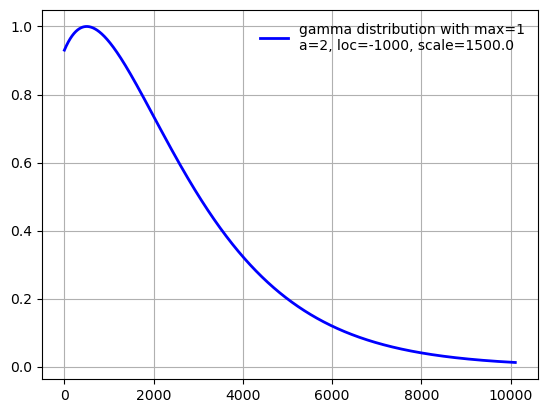

In [5]:
# Choose a subset of keywords to use... sample randomly with weights set by a gamma function as below
#    Don't simply use the KW weights as sample weights, as then you will almost never sample the lower-weight keywords
x = np.linspace(0, len(df_kw)-1, len(df_kw))
a, loc, scale = 2, -1000, 1.5e3  # parameters to define a gamma function for sampling probability of keywords
rv = gamma(a,loc,scale)
y = rv.pdf(x)
y_norm = y / y.max()

fig, ax = plt.subplots(1, 1)
ax.plot(x, y_norm, 'blue', lw=2, label=f'gamma distribution with max=1\na={a}, loc={loc}, scale={scale}')
ax.legend(loc='best', frameon=False)
ax.grid(visible=True)
plt.show()

In [6]:
# Sample the kw dataframe:
df_selected_kw = df_kw.sample(n=N_KEYWORDS, weights=y, replace=False, random_state=43)  # ignore_index=True
df_selected_kw.sort_index(inplace=True)
print(df_selected_kw.info(), "\n\n", df_selected_kw.head())

# Alternate option: ignore the above and just take the first N_KEYWORDS keywords
# df_selected_kw = df_kw.iloc[:N_KEYWORDS].copy(deep=True)
# print(df_selected_kw.info(), "\n\n", df_selected_kw.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 8 to 9776
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   edge_ID  400 non-null    string
 1   weight   400 non-null    int64 
 2   kw_text  400 non-null    string
dtypes: int64(1), string(2)
memory usage: 12.5 KB
None 

    edge_ID   weight kw_text
8   E00008  4986442      工人
18  E00018  2978158      救援
19  E00019  2525647      工地
20  E00020  2477672      了解
27  E00027  1941442      当时


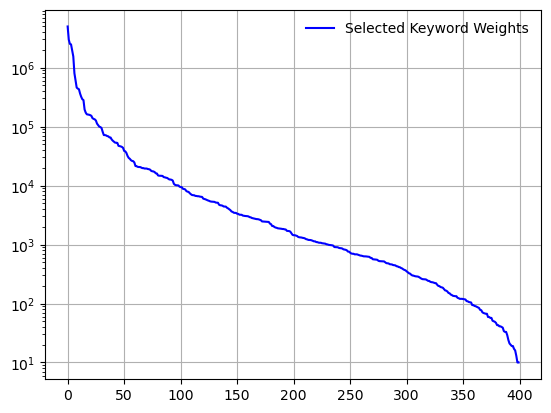

In [7]:
selected_weights = df_selected_kw.weight.to_numpy()
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, N_KEYWORDS-1, N_KEYWORDS), selected_weights, 'blue', ms=4, label=f'Selected Keyword Weights')
ax.legend(loc='best', frameon=False)
ax.grid(visible=True)
ax.semilogy()
plt.show()

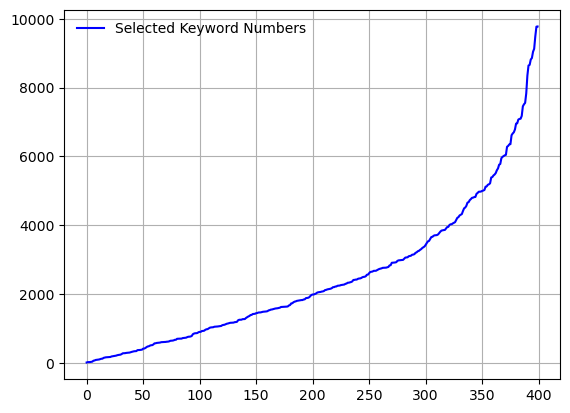

In [8]:
selected_kw_numbers = df_selected_kw.index
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, N_KEYWORDS-1, N_KEYWORDS), selected_kw_numbers, 'blue', ms=4, label=f'Selected Keyword Numbers')
ax.legend(loc='best', frameon=False)
ax.grid(visible=True)
# ax.semilogy()
plt.show()

In [9]:
# Now do a merge on the graph dataframe with the selected_kw dataframe, using key=edge_ID so we select only edges containing selected keywords
df_selected_kw_graph = df_graph.merge(df_selected_kw, how='inner', on='edge_ID')  # --> < 7 sec for 650 keywords; 1_709_335 edges
print(df_selected_kw_graph.info(), "\n\n", df_selected_kw_graph.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303896 entries, 0 to 1303895
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   from     1303896 non-null  string
 1   to       1303896 non-null  string
 2   edge_ID  1303896 non-null  string
 3   weight   1303896 non-null  int64 
 4   kw_text  1303896 non-null  string
dtypes: int64(1), string(4)
memory usage: 59.7 MB
None 

   from   to edge_ID   weight kw_text
0   V0   V2  E00008  4986442      工人
1   V0  V10  E00008  4986442      工人
2   V0  V12  E00008  4986442      工人
3   V0  V13  E00008  4986442      工人
4   V0  V15  E00008  4986442      工人


In [10]:
# Compute new weights for the graph --> 2.5 minutes for 650 keywords and 1.71 million edges (largest weight E00008 = 933_436... was previously 4_986_442)
df1 = df_selected_kw_graph[['from','to','edge_ID']].groupby(['from','to'], as_index=True).agg({'edge_ID': ['count', 'unique']}).reset_index(drop=True)
df1.columns = pd.Index(['weight','edge_ID'])   # df.columns.to_flat_index()
df1 = df1.explode('edge_ID', ignore_index=True)
df1.edge_ID = df1.edge_ID.astype("string")
df1 = df1.groupby('edge_ID', as_index=False).agg({'weight': 'sum'}) # .reset_index(drop=False)
print(df1.head())

  edge_ID  weight
0  E00008  745825
1  E00018  403515
2  E00019  405842
3  E00020  379592
4  E00027  298801


In [11]:
# Now do a merge on the graph dataframe with the selected_kw dataframe, using key=kw_text so we select only edges containing selected keywords
df_reweighted_graph = df_selected_kw_graph[['from','to','edge_ID']].merge(df1, how='inner', on='edge_ID') # --> 1.3 sec for 650 keywords; 1_709_335 edges
print(df_reweighted_graph.info(), "\n\n", df_reweighted_graph.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303896 entries, 0 to 1303895
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   from     1303896 non-null  string
 1   to       1303896 non-null  string
 2   edge_ID  1303896 non-null  string
 3   weight   1303896 non-null  int64 
dtypes: int64(1), string(3)
memory usage: 49.7 MB
None 

   from   to edge_ID  weight
0   V0   V2  E00008  745825
1   V0  V10  E00008  745825
2   V0  V12  E00008  745825
3   V0  V13  E00008  745825
4   V0  V15  E00008  745825


In [12]:
# rename edge_ID so it will be unique for every edge, but retain memory of where it came from
df_reweighted_graph.edge_ID = df_reweighted_graph.index.astype("string") + df_reweighted_graph.edge_ID # --> 1.8 sec for 650 keywords; 1_709_335 edges
print(df_reweighted_graph.info(), "\n\n", df_reweighted_graph.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303896 entries, 0 to 1303895
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   from     1303896 non-null  string
 1   to       1303896 non-null  string
 2   edge_ID  1303896 non-null  string
 3   weight   1303896 non-null  int64 
dtypes: int64(1), string(3)
memory usage: 49.7 MB
None 

   from   to  edge_ID  weight
0   V0   V2  0E00008  745825
1   V0  V10  1E00008  745825
2   V0  V12  2E00008  745825
3   V0  V13  3E00008  745825
4   V0  V15  4E00008  745825


## Create the Graph in iGraph

In [13]:
# Now create the graph with iGraph from pd.DataFrame; roughly 75sec for 12_227_117 edges, and 7 seconds for 1_709_335 edges
Gi = Graph.DataFrame(df_reweighted_graph, directed=False, vertices=None, use_vids=False)
# print(Gi.summary(verbosity=1))  #### THIS CRASHES VSCODE
print(Gi.degree([0, 2, 13]))  # test = [883, 835, 2364] for reweighted 650 keyword graph

[883, 835, 2183]


In [14]:
print(Gi.vertex_attributes())
print(Gi.edge_attributes())

['name']
['edge_ID', 'weight']


In [15]:
# Write the graph to disk as a pickle file in case we screw something up below
Gi.write(BASE_DIRECTORY / "KW650_Multiedge_Weighted_Undirected_iGraph400gamma.pkl", format="pickle")  # 2.2 sec for 650 keywords; 1_709_335 edges, 45 MB file
# Gi.write_edgelist(BASE_DIRECTORY / 'KW650_Multiedge_Weighted_Undirected_iGraph.edgelist') #, names=True, weights='weight', delimiter='\t', encoding='utf-8', write_weights=True, format='edgelist', vertex_name_attr='name', edge_name_attr='edge_ID', edge_attr='weight')

## Divide Graph into Communities

In [16]:
# Read graph as a pickle file from disk if no changes from previous run
Gi = ig.read(BASE_DIRECTORY / "KW650_Multiedge_Weighted_Undirected_iGraph400gamma.pkl", format="pickle")  # 1.5 sec for 650 keywords; 1_709_335 edges, 45 MB file

In [17]:
"""
Summary representation of a graph.


The summary representation includes a header line and the list of edges. The header line consists of IGRAPH, followed by a four-character long code, the number of vertices, the number of edges, two dashes (--) and the name of the graph (i.e. the contents of the name attribute, if any). For instance, a header line may look like this:

    IGRAPH U--- 4 5 --
The four-character code describes some basic properties of the graph. The first character is U if the graph is undirected, D if it is directed. The second letter is N if the graph has a vertex attribute called name, or a dash otherwise. The third letter is W if the graph is weighted (i.e. it has an edge attribute called weight), or a dash otherwise. The fourth letter is B if the graph has a vertex attribute called type; this is usually used for bipartite graphs. The code is followed by the number of vertices and edges, and two dashes (--) and the name of the graph (i.e. the contents of the name attribute, if any).
"""

Gi.summary(verbosity=0)  # 'IGRAPH UNW- 1362 1709335 -- \n+ attr: name (v), edge_ID (e), weight (e)'

'IGRAPH UNW- 1358 1303896 -- \n+ attr: name (v), edge_ID (e), weight (e)'

In [18]:
# First simplify the multigraph by summing edge weights between vertices... test a few weights to be sure simplification is working (note that degree does noy inclue weights in iGraph... it is just the number of edges.  Use "strength" to calculate sum of edge weights from a vertex)
print(Gi.degree([0, 2, 13]))  # test = [883, 835, 2364] for reweighted 650 keyword graph
print(Gi.strength([0, 2, 13], mode='all', loops=True, weights='weight'))  # test = [779463027.0, 779419060.0, 1373432890.0] for reweighted gamma-650 keyword graph
print(Gi.is_weighted(), Gi.is_directed(), Gi.is_simple())  # --> True False False

Gi.simplify(combine_edges={"weight":sum})  #{ig.Edge.attributes["weight"]: sum, ig.Edge.attributes["edge_ID"]: max})  # --> 0.9 sec for 650 keywords; 1_709_335 edges

print(Gi.is_weighted(), Gi.is_directed(), Gi.is_simple())  # --> True False True
print(Gi.degree([0, 2, 13]))  # test = [858, 835, 1153] for simplified reweighted 650 keyword graph... fewer edges=good
print(Gi.strength([0, 2, 13], mode='all', loops=True, weights='weight'))  # [779463027.0, 779419060.0, 1373432890.0]
Gi.summary(verbosity=0)  # 'IGRAPH UNW- 1362 685991 -- \n+ attr: name (v), weight (e)'

[883, 835, 2183]
[622802478.0, 622763875.0, 1091244866.0]
True False False
True False True
[858, 835, 1128]
[622802478.0, 622763875.0, 1091244866.0]


'IGRAPH UNW- 1358 635829 -- \n+ attr: name (v), weight (e)'

In [19]:
def Get_Communities(graph: Graph, funct: ig.clustering, is_VertexCluster: bool, **kwargs: dict) -> tuple[Union[ig.clustering.VertexClustering, ig.clustering.Dendrogram], float, float]:
    """
    Get_Communities -- Use the specified iGraph community detection function to get the communities in the graph, and return the communities, the elapsed time, and the modularity of the communities

    Arguments:
        graph {Graph} -- The graph to get the communities for.  Expected to be an undirected simple graph with edge weights. (simplified multigraph)
        funct {iGraph Clustering Method} -- The iGraph community detection function to use to get the communities
        is_VertexCluster {bool} -- True if the function returns a VertexClustering, False if it returns a Dendrogram
        kwargs {dict} -- Any additional arguments to pass to the function

    Returns:
        comms {Union(VertexClustering | Dendrogram)} -- The communities found by the function
        elapsed_time {float} -- The elapsed time in seconds to find the communities
        Q {float} -- The modularity of the communities
    """
    start_time = time.time()
    comms = funct(graph, **kwargs)
    elapsed_time = time.time() - start_time
    if not is_VertexCluster:
        comms = comms.as_clustering() # comms as a Dendrogram
    Q = graph.modularity(comms, weights='weight', directed=False)  # comms as a Vertex Cluster
    print(f"Time: {elapsed_time:.2f} sec;  Q: {Q:.3f} -- {funct.__name__}; Clusters: {comms.summary()}")
    return comms, elapsed_time, Q

In [20]:
cluster_options = [
    # {'function': Graph.community_spinglass, 'is_VertexCluster': True, 'kwargs': {'weights': 'weight', 'spins': 300}},
    {'function': Graph.community_walktrap, 'is_VertexCluster': False, 'kwargs': {'weights': 'weight', 'steps': 3}},
    {'function': Graph.community_leiden, 'is_VertexCluster': True, 'kwargs': {'objective_function': 'modularity', 'weights': 'weight', 'n_iterations': 20}},
    {'function': Graph.community_multilevel, 'is_VertexCluster': True, 'kwargs': {'weights': 'weight', 'return_levels': False}},
    {'function': Graph.community_leading_eigenvector, 'is_VertexCluster': True, 'kwargs': {'weights': 'weight', "clusters": 10}},
    {'function': Graph.community_label_propagation, 'is_VertexCluster': True, 'kwargs': {'weights': 'weight'}},
    {'function': Graph.community_infomap, 'is_VertexCluster': True, 'kwargs': {'edge_weights': 'weight', 'trials': 25}},
    {'function': Graph.community_fastgreedy, 'is_VertexCluster': False, 'kwargs': {'weights': 'weight'}}
    # {'function': Graph.community_edge_betweenness, 'is_VertexCluster': False, 'kwargs': {'weights': 'weight', 'directed': False}},  # takes more than 9 hours; skip
    # {'function': Graph.community_optimal_modularity, 'is_VertexCluster': False, 'kwargs': {'weights': 'weight'}}, # NOTE: returns a tuple with clusters, Q; not suited for N>100 nodes
]

for c in cluster_options:
    # c['function'] = c['function'].__func__  # convert the method to a function
    if c['function'].__name__ == '_community_leiden':
        c['kwargs']['initial_membership'] = comms.membership  # use the previous community detection method as the initial membership for the next method
        print('hi')
    comms, delay, mod = Get_Communities(Gi, c['function'], c['is_VertexCluster'], **c['kwargs'])

Time: 11.80 sec;  Q: 0.061 -- _community_walktrap; Clusters: Clustering with 1358 elements and 7 clusters
hi
Time: 3.11 sec;  Q: 0.086 -- _community_leiden; Clusters: Clustering with 1358 elements and 3 clusters
Time: 0.88 sec;  Q: 0.081 -- _community_multilevel; Clusters: Clustering with 1358 elements and 3 clusters
Time: 2.20 sec;  Q: 0.077 -- _community_leading_eigenvector; Clusters: Clustering with 1358 elements and 3 clusters
Time: 0.27 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1358 elements and 1 clusters
Time: 10.54 sec;  Q: 0.000 -- _community_infomap; Clusters: Clustering with 1358 elements and 1 clusters
Time: 2.15 sec;  Q: 0.077 -- _community_fastgreedy; Clusters: Clustering with 1358 elements and 4 clusters


In [21]:
# Partition the graph into communities using various methods to see if one is better than another
# cluster_options = [
#     Graph.community_multilevel, 
#     Graph.community_leiden, 
#     Graph.community_leading_eigenvector, 
#     Graph.community_infomap, 
#     Graph.community_fastgreedy, 
#     Graph.community_walktrap, 
#     Graph.community_spinglass, 
#     Graph.community_label_propagation] # not including community_edge_betweenness because it takes too long

top 400 kws:
Time: 19.15 sec;  Q: 0.019 -- _community_walktrap; Clusters: Clustering with 1367 elements and 2 clusters
hi
Time: 5.60 sec;  Q: 0.021 -- _community_leiden; Clusters: Clustering with 1367 elements and 2 clusters
Time: 1.63 sec;  Q: 0.021 -- _community_multilevel; Clusters: Clustering with 1367 elements and 3 clusters
Time: 2.72 sec;  Q: 0.021 -- _community_leading_eigenvector; Clusters: Clustering with 1367 elements and 2 clusters
Time: 0.31 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1367 elements and 1 clusters
Time: 14.87 sec;  Q: 0.000 -- _community_infomap; Clusters: Clustering with 1367 elements and 1 clusters
Time: 4.98 sec;  Q: 0.021 -- _community_fastgreedy; Clusters: Clustering with 1367 elements and 2 clusters


top 800 kws:
Time: 18.64 sec;  Q: 0.012 -- _community_walktrap; Clusters: Clustering with 1367 elements and 4 clusters
hi
Time: 4.87 sec;  Q: 0.021 -- _community_leiden; Clusters: Clustering with 1367 elements and 3 clusters
Time: 1.28 sec;  Q: 0.022 -- _community_multilevel; Clusters: Clustering with 1367 elements and 3 clusters
Time: 2.65 sec;  Q: 0.021 -- _community_leading_eigenvector; Clusters: Clustering with 1367 elements and 2 clusters
Time: 0.32 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1367 elements and 1 clusters
Time: 14.71 sec;  Q: 0.000 -- _community_infomap; Clusters: Clustering with 1367 elements and 1 clusters
Time: 4.86 sec;  Q: 0.022 -- _community_fastgreedy; Clusters: Clustering with 1367 elements and 2 clusters

top 650 kws:
Time: 19.86 sec;  Q: 0.012 -- _community_walktrap; Clusters: Clustering with 1367 elements and 4 clusters
hi
Time: 5.70 sec;  Q: 0.022 -- _community_leiden; Clusters: Clustering with 1367 elements and 2 clusters
Time: 1.60 sec;  Q: 0.022 -- _community_multilevel; Clusters: Clustering with 1367 elements and 3 clusters
Time: 2.51 sec;  Q: 0.021 -- _community_leading_eigenvector; Clusters: Clustering with 1367 elements and 2 clusters
Time: 0.31 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1367 elements and 1 clusters
Time: 15.24 sec;  Q: 0.000 -- _community_infomap; Clusters: Clustering with 1367 elements and 1 clusters
Time: 5.02 sec;  Q: 0.022 -- _community_fastgreedy; Clusters: Clustering with 1367 elements and 2 clusters

random gamma 650 kws

Time: 15.01 sec;  Q: 0.057 -- _community_walktrap; Clusters: Clustering with 1362 elements and 4 clusters
hi
Time: 3.73 sec;  Q: 0.081 -- _community_leiden; Clusters: Clustering with 1362 elements and 3 clusters
Time: 0.99 sec;  Q: 0.081 -- _community_multilevel; Clusters: Clustering with 1362 elements and 3 clusters
Time: 2.71 sec;  Q: 0.073 -- _community_leading_eigenvector; Clusters: Clustering with 1362 elements and 3 clusters
Time: 0.23 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1362 elements and 1 clusters
Time: 11.45 sec;  Q: 0.000 -- _community_infomap; Clusters: Clustering with 1362 elements and 1 clusters
Time: 2.53 sec;  Q: 0.076 -- _community_fastgreedy; Clusters: Clustering with 1362 elements and 3 clusters

Time: 18.56 sec;  Q: 0.057 -- _community_walktrap; Clusters: Clustering with 1362 elements and 6 clusters
Time: 1.14 sec;  Q: 0.078 -- _community_multilevel; Clusters: Clustering with 1362 elements and 3 clusters
Time: 1.86 sec;  Q: 0.075 -- _community_leiden; Clusters: Clustering with 1362 elements and 4 clusters
Time: 2.61 sec;  Q: 0.073 -- _community_leading_eigenvector; Clusters: Clustering with 1362 elements and 3 clusters
Time: 0.18 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1362 elements and 1 clusters
Time: 11.63 sec;  Q: 0.000 -- _community_infomap; Clusters: Clustering with 1362 elements and 1 clusters
Time: 2.92 sec;  Q: 0.076 -- _community_fastgreedy; Clusters: Clustering with 1362 elements and 3 clusters

Time: 1.16 sec;  Q: 0.070 -- _community_multilevel
Time: 1.78 sec;  Q: 0.081 -- _community_leiden
Time: 2.39 sec;  Q: 0.073 -- _community_leading_eigenvector
Time: 11.57 sec;  Q: 0.000 -- _community_infomap

Time: 1.30 sec;  Q: 0.081 -- _community_multilevel; Clusters: Clustering with 1362 elements and 3 clusters
Time: 2.22 sec;  Q: 0.081 -- _community_leiden; Clusters: Clustering with 1362 elements and 3 clusters
Time: 2.41 sec;  Q: 0.073 -- _community_leading_eigenvector; Clusters: Clustering with 1362 elements and 3 clusters
Time: 0.20 sec;  Q: 0.000 -- _community_label_propagation; Clusters: Clustering with 1362 elements and 1 clusters


SyntaxError: invalid syntax (3655555748.py, line 16)

### To Do: Find optimal method of partitioning communities (speed, modularity value)
</br>

### Also: Verify modularity close to Shu's reported values for the original experiment

In [ ]:
stop here with KeyErrorrr


## Several Useful Magic Commands for Jupyter Notebook

1. %lsmagic -- List currently available magic functions.

    * %quickref -- This magic command explains all the magic command that exists in the Jupyter Notebook with detail.  
    
    <br>  
2. %sx -- Shell execute - run shell command and capture output (!! is short-hand).  

    * %system -- Shell execute - run shell command and capture output (!! is short-hand).  
    
    <br>  
3. %run -- Run a file.  

    * You can run a python file from your jupyter notebook using the following code:  %run \<file name\>  
    
    <br>  
4. %reload_ext -- Reload an IPython extension by its module name.  
  

5. %macro -- Define a macro for future re-execution.  It accepts ranges of history....  
  

6. %reset -- Resets the namespace by removing all names defined by the user, if...  

    * %reset_selective -- Resets the namespace by removing names defined by the user.  
    
    <br>  
7. %page -- Display the object as a page of formatted text.  
  
  
8. %pdoc -- Print the docstring for an object.  
  
  
9. %pfile -- Print the source code for an object.  It finds the file where an object is defined.  
  
  
7. %psource -- Print (or run through pager) the source code for an object.  This is similar to the built-in help() function, but with some extra features.  
  
    * %psource \<object name\>  
    
    <br>  
8. %pprint -- Toggle pretty printing on/off.  

    * %precision -- Set floating point precision for pretty printing.  
    
    <br>  
9. %%time -- Time a cell.  
  
10. %prun -- Run a statement through the python code profiler.  Another magic command that has something to do with time, %prun is a specific magic command to evaluate how much time your subfunctions are involved to execute each function.  What is amazing about %prun is that shows the table where you could see the number of times each internal function was called within the statement, the time each call took, and the cumulative time of all runs of the function. It also shows the total time for the statement.  

    * %prun sns.load_dataset('mpg')  

    <br>  
11. %time -- Time execution of a Python statement or expression.  

    * %timeit -- Time execution of a Python statement or expression  
    * %timeit \<your code\>  
    <br> If you want to time a single line of code, you can use the %timeit magic command. This will time how long it takes to run the code. You can also use the -n option to specify the number of times you want to run the code. You can also use the -r option to specify the number of times you want to repeat the timing.  
    <br>  
12. %memit -- If you want to measure the memory usage of a single line of code, you can use the %memit magic command. This will measure the memory usage of the code. You can also use the -n option to specify the number of times you want to run the code. You can also use the -r option to specify the number of times you want to repeat the timing.  

15. %lprun -- If you want to profile a single line of code, you can use the %lprun magic command. This will open the line profiler and you can use the commands to inspect the code. You can use the following commands to navigate through the code.  

    * n – next line
    * s – step into function
    * c – continue until next breakpoint
    * q – quit debugger  

    <br>  
16. %mprun -- If you want to profile memory usage of a single line of code, you can use the %mprun magic command. This will open the memory profiler and you can use the commands to inspect the code. You can use the above commands to navigate through the code.  
  

17. %who -- List all variables defined within the current notebook.  You can pass it a data type after command name to list only variables of the specific data type. Or, can append _ls to get a sorted list, or append 's' to get extra info    

    * %who str, %who list
    * %who_ls -- Return a sorted list of all interactive variables.
    * %whos -- Like %who, but gives some extra information about each variable.  
    * %pinfo -- even more detailed information about the variable such as type, value, string form, and docstring. --> %pinfo <variable>
    * %pinfo2 -- provides yet more detailed info than pinfo  

    <br>  
18. %xdel -- Delete a variable, trying to clear it from anywhere that...  
  

19. %env -- List all environmental variables, and set environmental variables.  

    * %set_env also works for setting variables, similar to:  %env NEW_VAR=Users/konki  

    <br>  
20. %load -- Load code into the current frontend.  

    * %load_ext -- Load an IPython extension by its module name.  
    * %loadpy -- Alias of \`%load\`  
    
    <br> This is a very useful command if you already have a python file with certain functions defined and you need to use them in the current notebook.  In order to illustrate we take an example of the file rectangle.py which consists of the following code.  
    ```
    def calculate_area(len, height):  
        return len * height * 2  
    ```
    <br> You can load the file content by executing the code:  %load rectangle.py
    <br> Once you run the cell you should get the content of the file within the cell.  Now just run the cell with the loaded code and you will be able to use the functions that were defined within the original file. You can now calculate the rectangle area.  
    ```
    calculate_area(2,4)  
    ```  
    <br>  
21. %pycat -- Read a Python file into your Jupyter Notebook... You could do it as well using the %pycat magic command, like:  %pycat rectangle.py  
  
22. %%writefile -- What if you already have all that amazing function you code and want to save it in the python file. Sure, you can open another IDE and copy+paste the file, but there is an easier way to do it. We can use the magic command %%writefile to achieve the same result.  
    ```
    %%writefile test.py  
    def number_awesome(x):  
        return 9  
    ```  
    
    <br>  
23. %store -- What if you work on a project in one notebook and want to pass around the variables you had into another notebook. You do not need to pickle it or save it in some object file.  <br>Our previous Jupyter Notebook has the ‘df’ variable containing the mpg data frame. Should I want to move this ‘df’ variable into another Notebook, I only need to type \<%store df\>. This will store the variable ‘df’ into the memory of the current kernel. Now, I can move to another Notebook and type \<%store -r df\>. This will retrieve the variable ‘df’ from the memory of the current kernel. You can also use the -d option to delete the variable from the memory of the current kernel.  
  
24. %debug -- If you have an error in your code, you can use the %debug magic command to debug it. This will open the debugger and you can use the commands to inspect the error. You can use the following commands to navigate through the code.  

    * n – next line
    * s – step into function
    * c – continue until next breakpoint
    * q – quit debugger  
    
    <br>  
25. %pdb -- If you want to automatically open the debugger when an error occurs, you can use the %pdb magic command. This will automatically open the debugger when an error occurs. You can use the above commands to navigate through the code.  


In [ ]:
import sys
try:
    for i in range(5):
        if i == 1:
            raise UserWarning('Exit Early')
except:
    print('Early Exit')
    sys.exit()

# I had the same question and found a very simple solution here:
# There is a surprisingly simple way to turn off specific cells in Jupyter Notebook without having to manually comment-out chunks of code.

# The simple solution is to place the cursor into the cell that you want to silence, then press Esc + r. The cell will then transform into “raw” (Raw NBConvert) format and be skipped-over when the entire script is run.
# To revert it back, press Esc + y to return it to “code” format for re-inclusion.

# In the command mode (toggle via the Esc key) press r in the keyboard, the cell won't be run. To make it active again press Esc+y.

Early Exit


AssertionError: 